In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
import os

In [3]:
import ROOT
import h5py

In [4]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText

In [5]:
from uncertainties import ufloat, unumpy

In [6]:
def get_bin_sizes(bin_edges):
    return np.abs(np.diff(bin_edges))

In [7]:
TYPE = 14
NAME = r'gevgen_{0}'.format(TYPE)
CACHE = '/data/icecube/data/NuTeV/{0}/cache.hdf5'.format(TYPE)
DATA_NU = '/data/icecube/data/NuTeV/nutev_data/data/nutevpack/NuVec.dat'
DATA_NUBAR= '/data/icecube/data/NuTeV/nutev_data/data/nutevpack/NubarVec.dat'
Y_BINNING = np.array([0, 0.001, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.97, 1.0])
X_BINNING = np.array([0.0001, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
E_BINNING = np.array([30, 40, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200, 230, 260, 290, 320, 360])
Y_CENTERS = np.array([0.0005, 0.026, 0.075, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.935, 0.985])
X_CENTERS = np.array([0.015, 0.045, 0.08, 0.125, 0.175, 0.225, 0.275, 0.35, 0.45, 0.55, 0.65, 0.75])
E_CENTERS = np.array([35, 45, 55, 65, 75, 85, 95, 110, 130, 150, 170, 190, 215, 245, 275, 305, 340])
N_TARGET = 56
WA_NU = 0.677E-38 * N_TARGET
WA_NUBAR = 0.334E-38 * N_TARGET
print(WA_NU, WA_NUBAR)

3.7912e-37 1.8704e-37


In [8]:
is_cache = False
if os.path.isfile(CACHE):
    is_cache = True
print(is_cache)
if not is_cache:
    infile_nu = '/data/icecube/data/NuTeV/'+str(TYPE)+'/'+NAME+'.gst.root'
    infile_nubar = '/data/icecube/data/NuTeV/'+str(TYPE)+'/'+r'gevgen_-{0}.gst.root'.format(TYPE)
    input_file_nu = ROOT.TFile(infile_nu)
    input_file_nubar = ROOT.TFile(infile_nubar)
else:
    h5file = h5py.File(CACHE, 'r')
    for key in h5file.iterkeys():
        locals().update(dict([(key, np.array(h5file[key][:]))]))
    h5file.close()

True


In [9]:
def cache_events(in_arrays):
    h5file = h5py.File(CACHE, 'w')
    inarr_dict = dict(zip(STR_R, in_arrays))
    for key in inarr_dict.iterkeys():
        h5file.create_dataset(key, data=inarr_dict[key])
    h5file.close()

In [10]:
STR_R = ['pdg_array', 'xsec_array', 'energy_array', 'y_array', 'x_array', 'dis_array', 'weights', 'hitnucA']
if not is_cache:
    pdg_array, xsec_array, energy_array, y_array, x_array, dis_array, weights, hitnucA = [], [], [], [], [], [], [], []
    for event in input_file_nu.gst:
        pdg_array.append(event.neu)
        xsec_array.append(event.xsec * 1E-38)
        energy_array.append(event.Ev)
        y_array.append(event.y)
        x_array.append(event.x)
        dis_array.append(event.dis)
        weights.append(event.wght)
        hitnucA.append(event.A)
    for event in input_file_nubar.gst:
        pdg_array.append(event.neu)
        xsec_array.append(event.xsec * 1E-38)
        energy_array.append(event.Ev)
        y_array.append(event.y)
        x_array.append(event.x)
        dis_array.append(event.dis)
        weights.append(event.wght)
        hitnucA.append(event.A)
    pdg_array, xsec_array, energy_array, y_array, x_array, dis_array, weights, hitnucA = \
        map(np.array, (pdg_array, xsec_array, energy_array, y_array, x_array, dis_array, weights, hitnucA))
    cache_events((pdg_array, xsec_array, energy_array, y_array, x_array, dis_array, weights, hitnucA))
nu_mask = pdg_array > 0
nubar_mask = pdg_array < 0
print(xsec_array)
print(xsec_array.shape)

[  4.26148014e-36   3.20568848e-35   8.70505736e-36 ...,   3.86161249e-36
   6.23341528e-36   6.18216997e-37]
(2000000,)


In [11]:
weights = np.ones(len(weights))
print(weights)

[ 1.  1.  1. ...,  1.  1.  1.]


In [12]:
with open(DATA_NU, 'r') as f:
    table_nu = np.genfromtxt(f, usecols=range(9), skip_header=1)
with open(DATA_NUBAR, 'r') as f:
    table_nubar = np.genfromtxt(f, usecols=range(9), skip_header=1)

In [13]:
def decode_index(index):
    ybin = index % 100 - 1
    xbin = ((index % 10000) - ybin) / 100 - 1 - 1
    ebin = ((index % 1000000) - xbin*100 -ybin)/10000 - 1 - 1

    return [map(int, (ebin, xbin, ybin))]

nu_decoded_index, nubar_decoded_index = [], []
for index in table_nu[:,0]:
    nu_decoded_index.append(decode_index(index))
for index in table_nubar[:,0]:
    nubar_decoded_index.append(decode_index(index))
nu_decoded_index = np.vstack(nu_decoded_index)
nubar_decoded_index = np.vstack(nubar_decoded_index)
print(nu_decoded_index)

[[ 0  1  5]
 [ 0  1  6]
 [ 0  1  7]
 ..., 
 [16 11  2]
 [16 11  3]
 [16 11  4]]


In [14]:
nu_sys = table_nu[:,3:].T
nubar_sys = table_nubar[:,3:].T
print(nu_sys.shape)
nu_sys_err_2 = nu_sys[0]**2 + nu_sys[1]**2 + nu_sys[2]**2 + nu_sys[3]**2 + nu_sys[4]**2 + nu_sys[5]**2
nubar_sys_err_2 = nubar_sys[0]**2 + nubar_sys[1]**2 + nubar_sys[2]**2 + nubar_sys[3]**2 + nubar_sys[4]**2 + nubar_sys[5]**2
nu_xsec_array = unumpy.uarray(table_nu[:,1], np.sqrt(table_nu[:,2]**2 + nu_sys_err_2))
nubar_xsec_array = unumpy.uarray(table_nubar[:,1], np.sqrt(table_nubar[:,2]**2 + nubar_sys_err_2))

(6, 1423)


In [15]:
nu_data_matrix = np.zeros(map(len, (E_CENTERS, X_CENTERS, Y_CENTERS)))
nubar_data_matrix = np.zeros(map(len, (E_CENTERS, X_CENTERS, Y_CENTERS)))
nu_data_matrix, nubar_data_matrix = unumpy.uarray(nu_data_matrix, nu_data_matrix), \
                                    unumpy.uarray(nubar_data_matrix, nubar_data_matrix)
print(nu_data_matrix.shape)
for idx, entry in enumerate(nu_decoded_index):
    nu_data_matrix[tuple(entry)] = nu_xsec_array[idx]
for idx, entry in enumerate(nubar_decoded_index):
    nubar_data_matrix[tuple(entry)] = nubar_xsec_array[idx]
nu_data_matrix, nubar_data_matrix = ma.masked_equal(nu_data_matrix, 0), ma.masked_equal(nubar_data_matrix, 0)

(17, 12, 13)


In [16]:
def make_histo(array, xsec_weights):
    hist, edges = np.histogram(array, bins=Y_BINNING)
    hist_w, edges = np.histogram(array, bins=Y_BINNING, weights=xsec_weights)
    hist_w2, edges = np.histogram(array, bins=Y_BINNING, weights=xsec_weights**2)

    u_hist = unumpy.uarray(hist, np.sqrt(hist))
    u_hist_w = unumpy.uarray(hist_w, np.sqrt(hist_w2))
    sigma, missing = [], []
    for idx in xrange(len(u_hist)):
        if u_hist[idx].n == 0:
            sigma.append(ufloat(0, 0))
            missing.append(1)
            continue
        missing.append(0)
        sigma.append(u_hist_w[idx] / u_hist[idx])
    sigma, missing = np.array(sigma), np.array(missing)
    
    #return ma.masked_array(sigma, mask=missing)
    return ma.masked_equal(u_hist, 0)

In [17]:
e_bin_sizes = get_bin_sizes(E_BINNING).astype(float)
x_bin_sizes = get_bin_sizes(X_BINNING).astype(float)
y_bin_sizes = get_bin_sizes(Y_BINNING).astype(float)

NU_HISTOGRAMS, NUBAR_HISTOGRAMS = {}, {}
SCALING_NU, SCALING_NUBAR = [], []
for e_idx, e_bin in enumerate(E_BINNING[:-1]):
    energy_mask = (energy_array >= e_bin) & (energy_array < E_BINNING[e_idx + 1])
    xsec_weight = xsec_array[energy_mask] / 1E-38
    y_array_e = y_array[energy_mask]
    x_array_e = x_array[energy_mask]
    nu_mask_e = nu_mask[energy_mask]
    nubar_mask_e = nubar_mask[energy_mask]
    
    sigma_nu = sigma_nubar = 0
    NU_HISTOGRAMS[e_idx], NUBAR_HISTOGRAMS[e_idx] = {}, {}
    for x_idx, x_bin in enumerate(X_BINNING[:-1]):
        x_mask = (x_array_e >= x_bin) & (x_array_e < X_BINNING[x_idx+1])
        y_array_e_x = y_array_e[x_mask]
        xsec_weight_x = xsec_weight[x_mask]
        nu_mask_e_x = nu_mask_e[x_mask]
        nubar_mask_e_x = nubar_mask_e[x_mask]

        sigma_nu_x = make_histo(
            y_array_e_x[nu_mask_e_x], xsec_weight_x[nu_mask_e_x]
        )
        sigma_nu_x_e = sigma_nu_x * (1 / E_CENTERS[e_idx].astype(float))
        
        sigma_nubar_x = make_histo(
            y_array_e_x[nubar_mask_e_x], xsec_weight_x[nubar_mask_e_x]
        )
        sigma_nubar_x_e = sigma_nubar_x * (1 / E_CENTERS[e_idx].astype(float))
        
        factors = y_bin_sizes * x_bin_sizes[x_idx]
        #factors = 1 / (y_bin_sizes)
        NU_HISTOGRAMS[e_idx][x_idx] = sigma_nu_x_e * factors
        NUBAR_HISTOGRAMS[e_idx][x_idx] = sigma_nubar_x_e * factors
        sigma_nu += np.sum(unumpy.nominal_values(sigma_nu_x_e.data) * factors)
        sigma_nubar += np.sum(unumpy.nominal_values(sigma_nubar_x_e.data) * factors)

    SCALING_NU.append((WA_NU / 1E-38) / sigma_nu)
    SCALING_NUBAR.append((WA_NUBAR / 1E-38) / sigma_nubar)
SCALING_NU, SCALING_NUBAR = map(ma.masked_invalid, (SCALING_NU, SCALING_NUBAR))
print(SCALING_NU)
print(SCALING_NUBAR)

[2.426977309212398 3.974672007208043 6.03188276551191 8.579313493074043
 11.134085799813382 14.30434507620743 18.24657708748219 12.245286521994359
 17.386557809605172 22.510273616559772 30.368683752850366
 38.983517035055726 32.5946162567942 41.35347142196327 54.433669131400116
 66.22014553038325 62.0075361019056]
[1.3181918989164512 2.1874236992949116 3.2755967325400395 4.677781779673906
 6.141643806446561 7.886673834678114 9.980131429121844 6.761569662088913
 9.459621999423003 12.502935444674012 16.61208413064538 21.389167943726054
 17.723575845841932 22.5274132876652 29.618682763489044 36.86987377202478
 33.939230957763534]


In [18]:
def format_axis(ax, x_label=r'', title=r'', lhs=False, ylim=None):
    ax.set_title(title)

    ax.set_xlim(np.min(Y_BINNING), np.max(Y_BINNING))
    for xmaj in Y_BINNING:
        ax.axvline(x=xmaj, ls=':', color='gray', alpha=0.4, linewidth=1)
    if x_label == r'':
        ax.get_xaxis().set_ticks([])
    else:
        ax.set_xlabel(x_label, fontsize=14)

    ax.tick_params(axis='y', labelsize=10)
    if not ylim is None:
        ax.set_ylim(ylim)
    #ax.set_ylim(1, 7000)
    #ax.set_yscale('log')
    for ymaj in ax.yaxis.get_majorticklocs():
        ax.axhline(y=ymaj, ls=':', color='gray', alpha=0.4, linewidth=1)
    if not lhs:
        ax.get_yaxis().set_ticks([])
        xticks = ax.xaxis.get_major_ticks()
        try:
            xticks[0].set_visible(False)
        except:
            pass
    else:
        yticks = ax.yaxis.get_major_ticks()
        for yt in yticks:
            yt.label.set_fontsize(9)
        yticks[0].set_visible(False)


def plot_histo(ax, histo, colour):
    histo_0 = np.concatenate(([histo[0]], histo))
    ax.step(
        Y_BINNING, unumpy.nominal_values(histo_0),
        alpha=0.5, color=colour, drawstyle='steps-pre', linewidth=2, linestyle=':'
    )
    ax.errorbar(
        Y_CENTERS, unumpy.nominal_values(histo),
        xerr=0, yerr=unumpy.std_devs(histo),
        capsize=0.7, alpha=1, color=colour, linestyle='None', markersize=0.5, linewidth=1
    )

    
def plot_data(ax, array, colour):
    ax.errorbar(
        Y_CENTERS, unumpy.nominal_values(array), xerr=0, yerr=unumpy.std_devs(array),
        capsize=1.5, alpha=1, color=colour, linestyle='-', markersize=3, linewidth=0.4
    )

WA nu/nubar 3.7912e-37 1.8704e-37
E: 9, 150
nu/nubar integral = 3.7912e-37 1.8704e-37


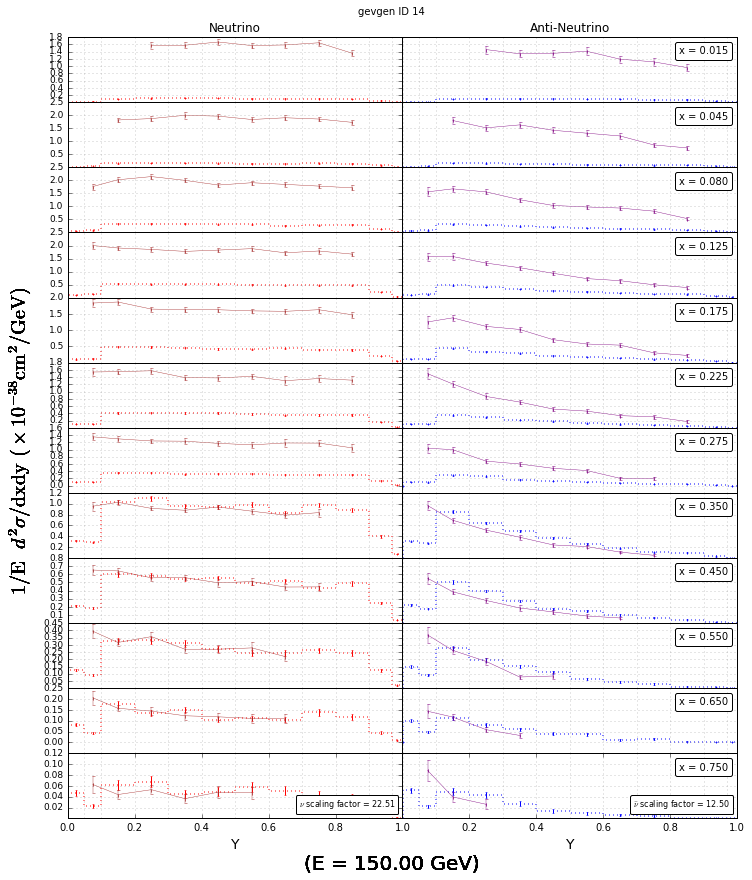

In [24]:
#E_PLOT = None
#E_PLOT = [65, 150, 245]
E_PLOT = [150]

print('WA nu/nubar {0} {1}'.format(WA_NU, WA_NUBAR))
for e_idx, e_bin in enumerate(E_BINNING[:-1]):
    e_cont = True
    if E_PLOT is None:
        e_cont = False
    else:
        for x in E_PLOT:
            if x >= e_bin and x < E_BINNING[e_idx + 1]:
                e_cont = False
    if e_cont:
        continue
    print(r'E: {0}, {1}'.format(e_idx, E_CENTERS[e_idx]))

    fig = plt.figure(figsize=[12, 14])
    fig.suptitle('gevgen ID {0}'.format(TYPE), y=0.93)
    gs = gridspec.GridSpec(len(X_CENTERS), 1)
    gs.update(hspace=0., wspace=0.)

    nu_int = 0
    nubar_int = 0
    for x_idx, x_bin in enumerate(X_BINNING[:-1]):
        gs0 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[x_idx],
                                               wspace=0, hspace=0, width_ratios=[1,1])

        ax0 = fig.add_subplot(gs0[0])

        plot_histo(ax0, NU_HISTOGRAMS[e_idx][x_idx] * SCALING_NU[e_idx], colour='red')
        plot_data(ax0, nu_data_matrix[e_idx][x_idx], colour='brown')
            
        ax1 = fig.add_subplot(gs0[1])
        plot_histo(ax1, NUBAR_HISTOGRAMS[e_idx][x_idx] * SCALING_NUBAR[e_idx], colour='blue')
        plot_data(ax1, nubar_data_matrix[e_idx][x_idx], colour='purple')

        nu_int += np.sum(NU_HISTOGRAMS[e_idx][x_idx]) * SCALING_NU[e_idx]
        nubar_int += np.sum(NUBAR_HISTOGRAMS[e_idx][x_idx]) * SCALING_NUBAR[e_idx]
        
        ylim = (np.min([ax0.get_ylim()[0], ax1.get_ylim()[0]]),
                np.max([ax0.get_ylim()[1], ax1.get_ylim()[1]]))
        #ylim = (0, 10)
        ax0.set_ylim(ylim)
        ax1.set_ylim(ylim)
        #ax1.set_ylim(ax0.get_ylim())
        if x_idx == 0:
            format_axis(ax0, title=r'Neutrino', lhs=True)
            format_axis(ax1, title=r'Anti-Neutrino')
        elif x_idx == len(X_CENTERS)-1:
            format_axis(ax0, x_label=r'Y', lhs=True)
            format_axis(ax1, x_label=r'Y')
            
            at0 = AnchoredText(r'$\nu$ scaling factor = {0:.2f}'.format(SCALING_NU[e_idx]),
                               prop=dict(size=8), frameon=True, loc=4)
            at0.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
            ax0.add_artist(at0)
            
            at1 = AnchoredText(r'$\bar\nu$ scaling factor = {0:.2f}'.format(SCALING_NUBAR[e_idx]),
                               prop=dict(size=8), frameon=True, loc=4)
            at1.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
            ax1.add_artist(at1)
        else:
            format_axis(ax0, lhs=True)
            format_axis(ax1)
        
        at = AnchoredText(r'x = {0:.3f}'.format(X_CENTERS[x_idx]),
                          prop=dict(size=10), frameon=True, loc=1)
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        ax1.add_artist(at)
        
        fig.text(0.055, 0.5, r'$\rm{1/E}$  $d^2\sigma/\rm{dx dy}$ $(\times 10^{-38}\rm{cm}^2/\rm{GeV})$',
                 rotation='vertical', va='center', size=20)
        fig.text(0.5, 0.075, r'(E = {0:.2f} GeV)'.format(E_CENTERS[e_idx]), ha='center', size=20)

    print('nu/nubar integral = {0} {1}'.format(nu_int.n * 1E-38, nubar_int.n * 1E-38))
    #fig.savefig('./images/NuTeV/gevgen/'+NAME+'_'+'{0:06.2f}_.png'.format(E_CENTERS[e_idx]), bbox_inches='tight')